# Notebook 2: Exploring movement space

---

<font size="3"> This notebook is the second of three methods notebooks associated with the pub "*Comparative analyses reveal substantial movement variation among amoeboid cells*". 

<font size="3"> Here, we will follow up on the first notebook ("*Data, shape components, and iterative window search*") and perform a set of analyses characterizing various aspects of the movement space.
 
<font size="3"> To begin, we will load the computed movement space and explore its structure and its relationship with the shape components used to generate it. 

---

## Loading data and diagnostic plots of movement space

<font size="3"> Set working directory

In [1]:
setwd('~/Desktop/comparative_amoeboid_crawling/')

<font size="3"> Source functions (suppressing output)

In [2]:
suppressPackageStartupMessages(source('01_functions//crawling_functions_0726022.R'))
library(repr)

<font size="3"> Load data

In [3]:
layout = readRDS('02_analysis_files/behavior_space_layout_annotated.RDS')
dat = readRDS('00_data/imoto_et_al_features_all_cells_051822.RDS')
s = readRDS('02_analysis_files/shape_pca_15_pcs.RDS')

---

<font size="3"> Movement space is a 2D array of points (i.e. windows made of **shape components**) connected to each other by discrete time steps (here, 1 frame). Given this, different visualization strategies can provides different types of information about the space.
 
<font size="3"> Visualizing movement space as **points** allows us to identify to the overall structure of the space (and some information about the relative density of points in certains regions).
 
<font size="3"> On the other hand, using **lines** to visualize movement space shows the pathways that connect the various points. This visualization contains information about how movements may be sequenced and the extent to which they are/are not stereotyped.

<font size="3"> Finally, calculating and visualizing the likelihood of data occurring in specific regions of the space (using a **probability density function**) allows us to identify movements that are more or less common.

---

<font size="3"> Plot behavior space as points, lines, and probability density function

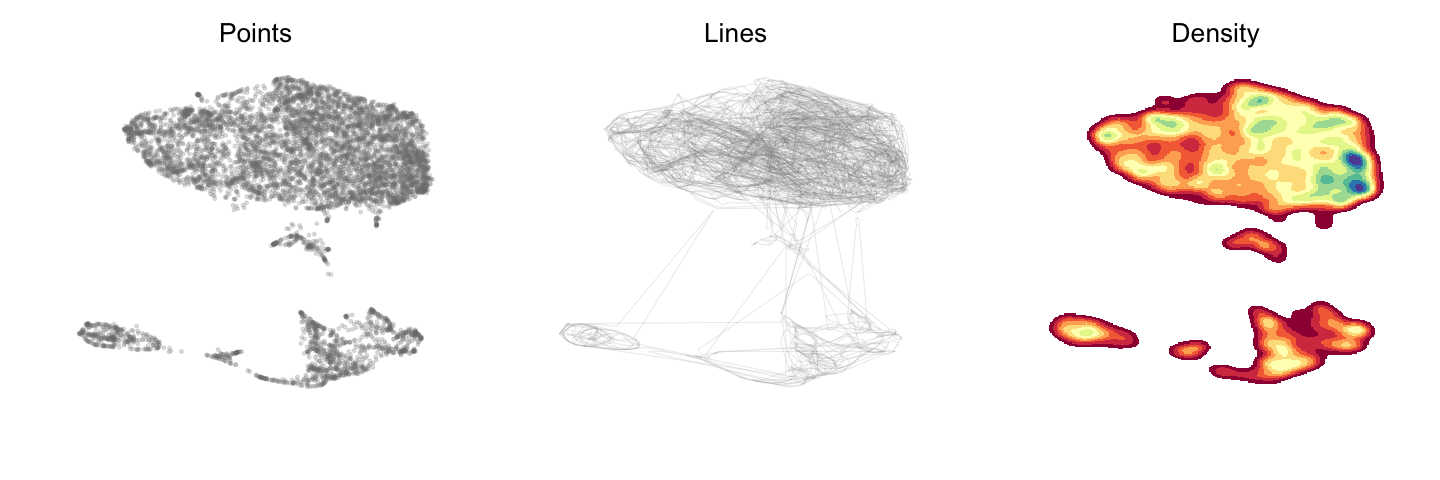

In [4]:
par(mfrow = c(1,3))
options(repr.plot.width=12, repr.plot.height=4)

#As points
plot(layout[,1:2],
     pch = 20,
     col = alpha('gray50', 0.25),
     lwd = 0.5,
     bty = 'n',
     xaxt = 'n',
     yaxt = 'n',
     xlab = '',
     ylab = '')
title(main = 'Points', font.main = 1, cex.main = 2)

#As lines
plot(layout[,1:2],
     type = 'l',
     col = alpha('gray50', 0.25),
     lwd = 0.5,
     bty = 'n',
     xaxt = 'n',
     yaxt = 'n',
     xlab = '',
     ylab = '')
title(main = 'Lines', font.main = 1, cex.main = 2)

#Probability density function
image(kde2d(layout$x,
            layout$y,
            h = 1,
            n = 300,
            lims = c(c(min(layout$x)-1, max(layout$x)+1), c(min(layout$y)-1, max(layout$y)+1))),
      col = c('white', RColorBrewer::brewer.pal(11, 'Spectral')),
      bty = 'n',
      xaxt = 'n',
      yaxt = 'n',
      xlab = '',
      ylab = '')
title(main = 'Density', font.main = 1, cex.main = 2)

---

<font size="3"> Building on the line visualization above, it can be useful to identify the common *directions* of trajectories through movement space by calculating a **vector field**.

---

<font size="3"> Plot as a vector field

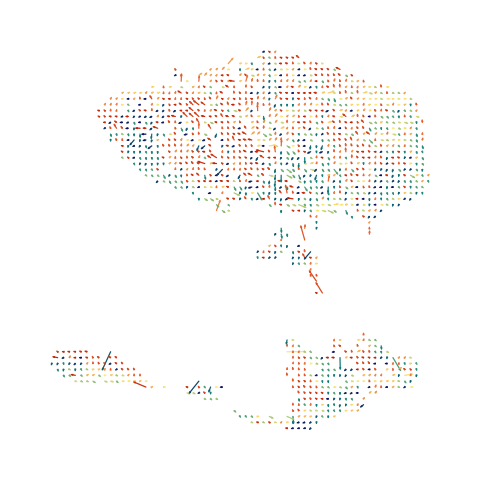

In [5]:
options(repr.plot.width=4, repr.plot.height=4)

plot_vector_field(layout, 
                  bin_umap = TRUE, 
                  n_bins = 64, 
                  color_by_theta = TRUE)

---

<font size="3"> Another important diagnostic visualization is the distribution in movement space of the **input features** (i.e. the 15 **shape components** we used). This helps us infer the relationship of the features to each other and the structure of the space, and builds and intuition about what types of movements characterize difference regions of the space.

---

<font size="3"> Plot distribution of shape components as a function of movement space

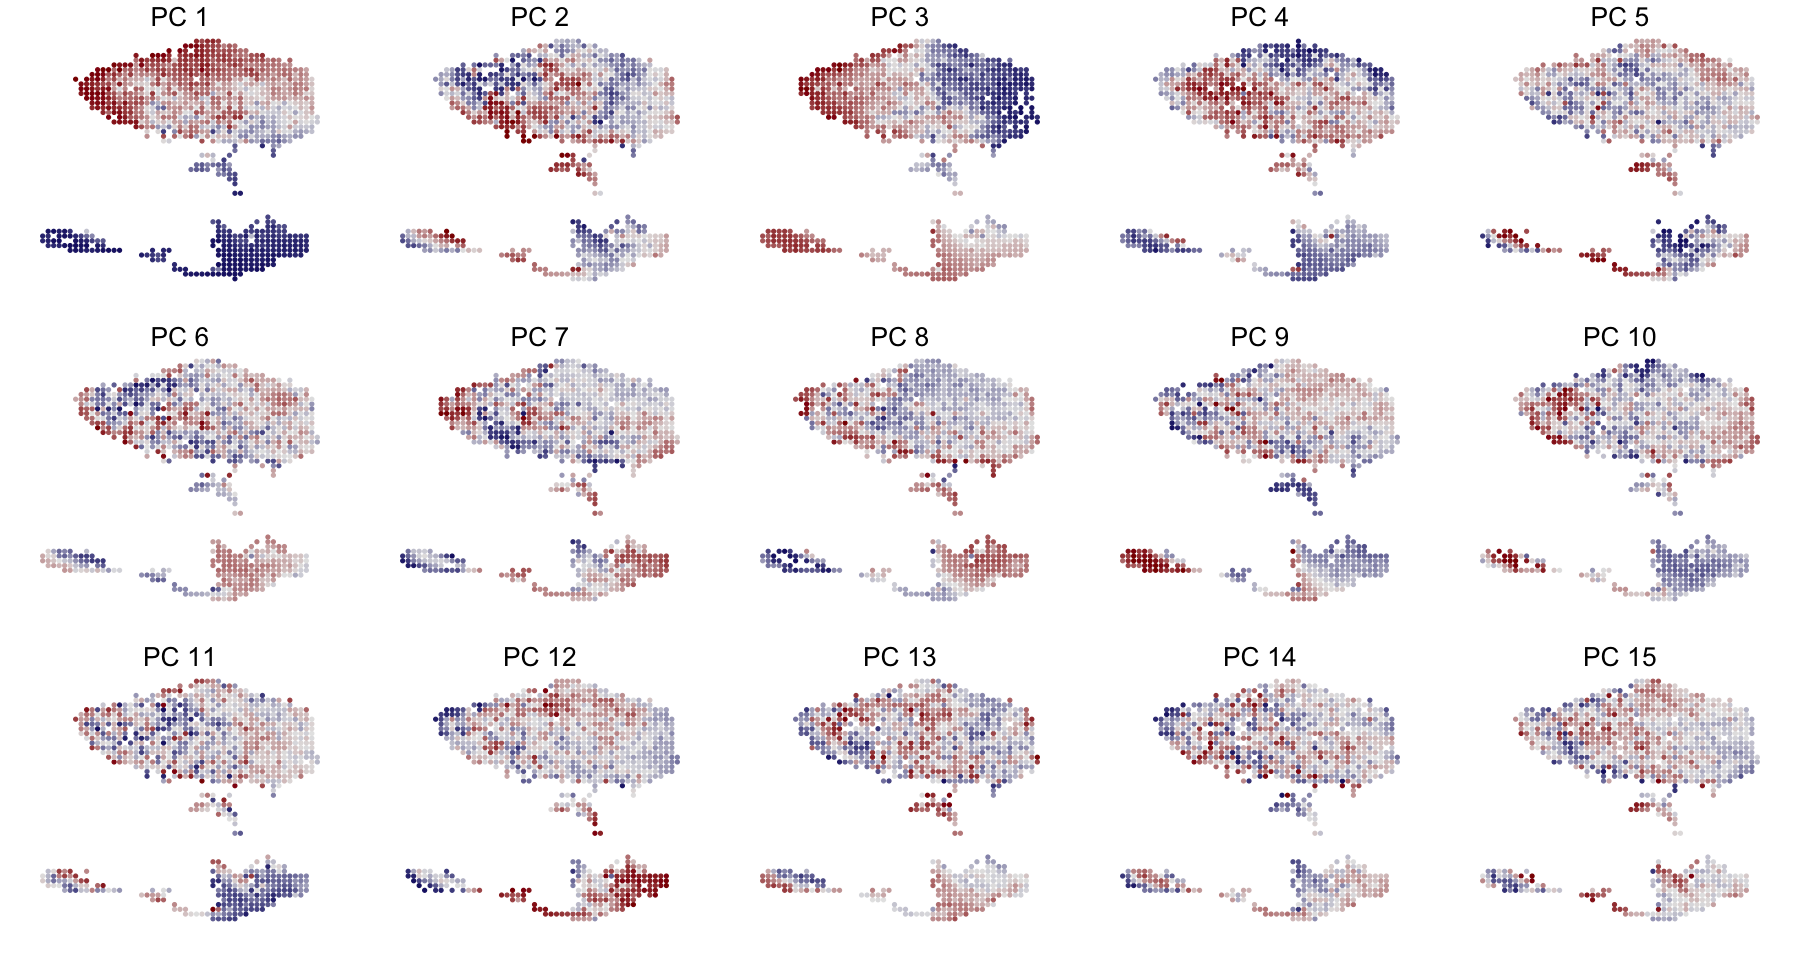

In [6]:
#Get PCs
feat = s[1:nrow(layout),]

#Set up plot
par(mfrow = c(3,5), mar = c(2,2,2,2))
options(repr.plot.width=15, repr.plot.height=8)

#Split features on layout positions
x = split(as.data.frame(feat), layout$xy_new)

#Loop through and plot
for(i in 1:15){
  #z = round(layout[,i], 2)
  z = round(unlist(lapply(x, function(y) mean(y[[i]]))), 2)
  z[z>quantile(z, probs = 0.99)] = quantile(z, probs = 0.99)
  z[z<quantile(z, probs = 0.01)] = quantile(z, probs = 0.01)

  if(min(z, na.rm = TRUE)>0|max(z, na.rm = TRUE)<0){

    cols = colorRampPalette(c('grey90', 'darkred'))(length(seq(min(z, na.rm = TRUE), max(z, na.rm = TRUE), 0.01)))
    names(cols) = round(seq(min(z), max(z), 0.01), 2)
    cols = cols[match(z, names(cols))]

  }else{

    cols1 = colorRampPalette(c('midnightblue', 'grey90'))(length(seq(min(z, na.rm = TRUE), 0, 0.01)))
    cols2 = colorRampPalette(c('grey90', 'darkred'))(length(seq(0.01, max(z, na.rm = TRUE), 0.01)))

    names(cols1) = round(seq(min(z), 0, 0.01), 2)
    names(cols2) = round(seq(0.01, max(z), 0.01), 2)

    cols = c(cols1, cols2)
    cols = cols[match(z, names(cols))]
  }

  plot(unlist(lapply(strsplit(names(z), "_"), function(v){v[1]})),
       unlist(lapply(strsplit(names(z), "_"), function(v){v[2]})),
       pch = 20,
       #cex = 0.75,
       col = cols,
       bty = 'n',
       xaxt = 'n',
       yaxt = 'n',
       xlab = '',
       ylab = '')

  title(main = paste('PC', i),
        cex.main = 2,
        font.main = 1)}

## Calculating and plotting geometric measures

---

<font size="3"> A common practice in the analysis of amoeboid movement is to characterize the how the shapes of cells change over time by calculating geometric measures such as circularity or area. 
 
<font size="3"> A nice feature of these measures is that they are more intuitive than abstract statistical values represented by the **shape components**. 
 
<font size="3"> In this code chunk we will calculate six geometric measurements of cell shape ('**circularity**', '**area**', '**perimeter**', '**major axis**', '**minor axis**', '**displacement**') and analyze their distributions in movement space.

---

<font size="3"> Convert shape data into a list of matrices

In [7]:
d = list()
for(i in 1:nrow(dat)){
  d[[rownames(dat)[i]]] = matrix(dat[i,], nrow = 64)
}

<font size="3"> Compute geometric measures

In [8]:
#Create empty list to save results
res = list()

#Loop through and calculate
for(i in 1:length(d)){

  #Get matrix and unlist
  x = d[[i]]
  z = expand.grid(1:nrow(x), 1:ncol(x))
  x = unlist(as.data.frame(x))

  #Get xy coordinates
  z = cbind(z[,2], z[,1])
  z = z[x>0,]

  #Calculate convex hull
  h = chull(as.matrix(z))
  #h <- c(h, h[1])
  h = z[h,]

  #Calculate perimeter
  p = swaRm::chullPerimeter(h[,1], h[,2])

  #Calculate area
  a = swaRm::chullArea(h[,1], h[,2])

  #Calculate heywood circularity
  circ = p/sqrt(4*pi*a)

  #Calculate major and minor axis
  e = fit.ellipse(h[,1], h[,2])

  #Save
  l = list(h, p, a, circ, e$major, e$minor)
  names(l) = c('convex_hull', 'perimeter', 'area', 'circularity', 'major_axis', 'minor_axis')
  res[[names(d)[i]]] = l
}

<font size="3"> Calculate displacement

In [9]:
#List all trials in the data set
u = unique(layout$trial)

#Create empty list to save results
dis = list()

#Loop through and calculate displacement per trial
for(i in 1:length(u)){
  z = c()
  tmp = d[layout$trial == u[i]]
  for(j in 1:(length(tmp)-1)){
    z = c(z, sum(abs(tmp[[j+1]]-tmp[[j]])))
  }
  z = c(z, NA)
  dis[[u[i]]] = z
}

#Unlist
dis = unlist(dis)

#Match to layout
dis = dis[1:nrow(layout)]

<font size="3"> Combine measures in a single list

In [10]:
l = list(unlist(lapply(res, function(x) x$circularity)),
         unlist(lapply(res, function(x) x$area)),
         unlist(lapply(res, function(x) x$perimeter)),
         unlist(lapply(res, function(x) x$major_axis)),
         unlist(lapply(res, function(x) x$minor_axis)),
         dis)
names(l) = c('Circularity', 'Area', 'Perimeter', 'Major axis', 'Minor axis', 'Displacement')

<font size="3"> Save

In [11]:
saveRDS(l, '02_analysis_files/geometric_measures_072622.RDS')

<font size="3"> Plot geometric measures as a function of behavior space (as in <b> Figure 2D </b> of Results Pub)

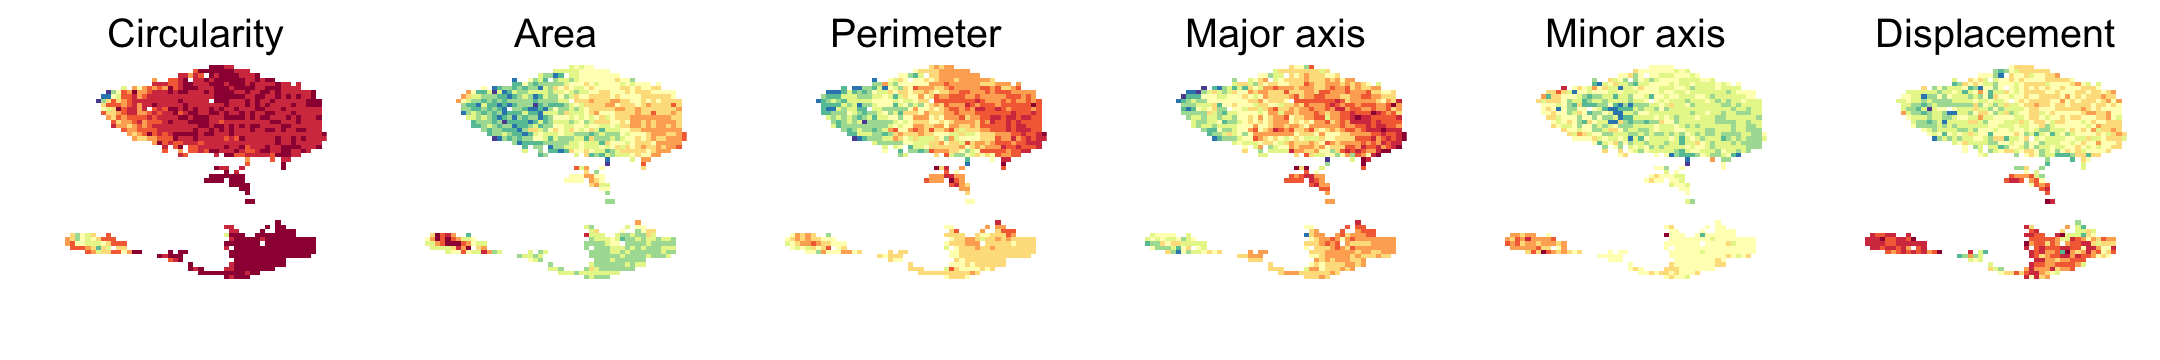

In [12]:
#Set up plot
par(mfrow = c(1,6))
options(repr.plot.width=18, repr.plot.height=3)

#Plot
for(i in 1:length(l)){
  plot_parameter(log(l[[i]]),
                 layout,
                 n_bins = 50,
                 col = RColorBrewer::brewer.pal(11, 'Spectral'))
  title(main = names(l)[i], font.main = 1, cex.main = 3)
}

---

<font size="3"> It is clear form these plots that all six aspects of cell geometry have unique distributions in movement space. 
 
<font size="3"> For example, **circularity** varies broadly between the left and righthand portions of movement space (reflecting the distribution of **shape component 3** in the previous chunk's plot).
 
<font size="3"> **Displacement**, on the other hand, has a more complex relationship with movement space. There is a broad separation between small (bottom) and large (top) values, with a further separation between intermediate (right) and large (left) in the top portion of the space.
   
<font size="3"> How do all of these complex geometric patterns fit together to determine cell shape? To answer this we can visualize cell shape as a function of movement space position (below).

---

<font size="3"> Calculate cell shape as a function of movement space

In [13]:
#Rebin layout
n_bins = 16
m = bin_umap(layout, n_bins = n_bins)$layout

#Filter cell postures to match layout length
d = dat[1:nrow(m),]

#Split on bin
d = split(as.data.frame(d), m$xy_new)

#Calculate col means
d = lapply(d, function(x) colMeans(x))

#Add empty elements to correspond to negative space
p = expand.grid(seq(1, n_bins+1, 1), seq(1, n_bins+1, 1))
p = paste(rev(p[,1]), p[,2], sep = '_')
d = d[match(p, names(d))]
names(d) = p
d = rev(d)

<font size="3"> Plot cell shape (as in <b> Figure 2C </b> of Results Pub)

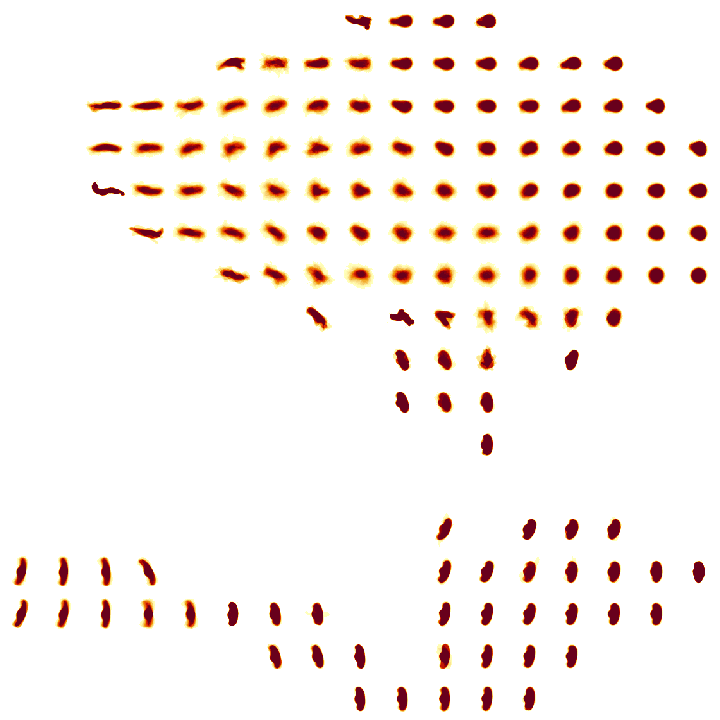

In [14]:
#Set up plot
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow = c(sqrt(length(d)),sqrt(length(d))), mar = c(0.05,0.05,0.05,0.05))

#Plot
for(i in 1:length(d)){
  if(!is.null(d[[i]])){
    image(matrix(d[[i]], nrow = 64),
          col = c('white', hcl.colors(20, "YlOrRd", rev = TRUE)),
          bty = 'n',
          xaxt = 'n',
          yaxt = 'n')
    #title(main = names(d)[i], font.main = 1, cex.main = 1.5)
  }else{
    plot(1:2, 1:2, type = 'n', bty = 'n', xaxt = 'n', yaxt = 'n')
  }
}

---

<font size="3"> Analyzing this visualization, we can start to get a sense of the types of characteristic cell shapes that define certain regions of movement space. 
  
<font size="3"> For example, mirroring the distribution of **circularity** observed above, we can see that from left to right cells range from quite elongated to increasingly circular.
 
<font size="3"> It is also apparent that certain broad regions, such as the bottom portion, are characterized by very consistent cell shapes. Could this be due to species or cell types differences related to specific portions of the space? In the next code chunk we will explore this.

---

## Analyzing cell type differences in behavior space

<font size="3"> In this chunk we will visualize how windows associated with each cell type in the data set are distributed in the movement space, and statistically compare their relationships with the geometric measurements calculated above.

---

<font size="3"> Plot cell type distributions in behavior space (as in <b> Figure 2B </b> of Results Pub)

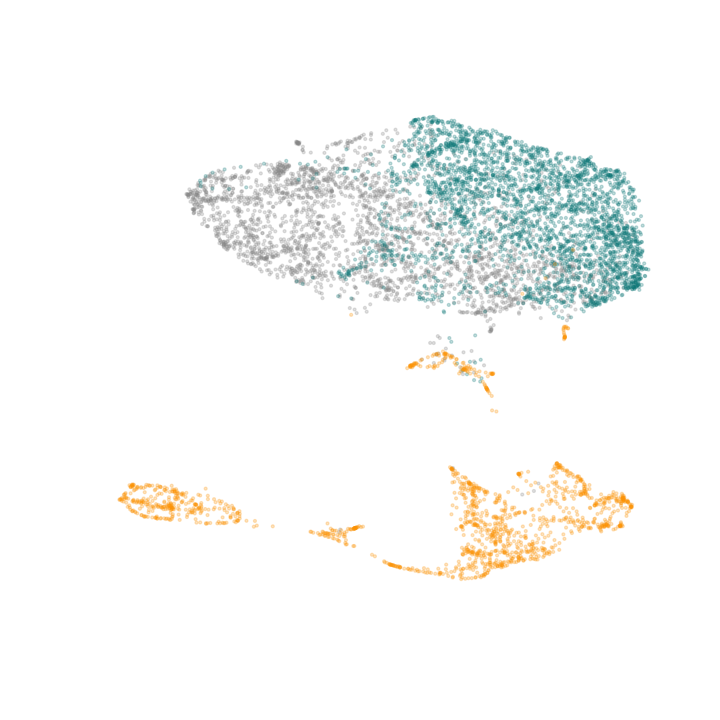

In [15]:
#Split behavior space layout on cell type
species = split(layout, layout$cell)

#Set up plot
options(repr.plot.width=6, repr.plot.height=6)

#Set up colors
cols = c('grey60', 'cyan4', 'orange')

#Plot
plot(species$dicty[,1:2],
     xlim = c(min(layout$x), max(layout$x)),
     ylim = c(min(layout$y), max(layout$y)),
     pch = 20,
     cex = 0.5,
     col = alpha(cols[1], 0.25),
     bty = 'n', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n')
points(species$hl60[,1:2], 
       pch = 20, 
       col = alpha(cols[2], 0.25), 
       cex = 0.5)
points(species$kera[,1:2], 
       pch = 20, 
       col = alpha(cols[3], 0.25), 
       cex = 0.5)


<font size="3"> Statistically compare geometric measures across cell types

In [16]:
#Split geometric measures by cell types
l2 = lapply(l, function(x) x[1:length(layout$coords)])
l2 = do.call(cbind, l2)
l2[is.na(l2)] = 0
l2 = split(as.data.frame(l2), layout$cell)
l2[['all']] = do.call(rbind, l2)

#Compare via dunn's test
for(i in 1:ncol(l2[[1]])){
  dunn.test::dunn.test(lapply(l2[1:3], function(x) x[,i]))
}

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 1032.6827, df = 2, p-value = 0


                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |          1          2
---------+----------------------
       2 |   22.43079
         |    0.0000*
         |
       3 |   30.37320   12.31150
         |    0.0000*    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2
  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 2806.6127, df = 2, p-value = 0


                           Comparison of x by group                            
                                (No adjustment)                                
Col Mean-|
Row Mean |          1          2
---------+----------------------
       2 |   52.41141
         |    0.0000*
         |
       3 |   15.33167  -27.75078
         |    0.0000*    0.0000*

alpha = 0.05
Reject

<font size="3"> Generate violin plots of geometric measures as a function of cell type (as in <b> Figure 2E </b> of Results Pub)

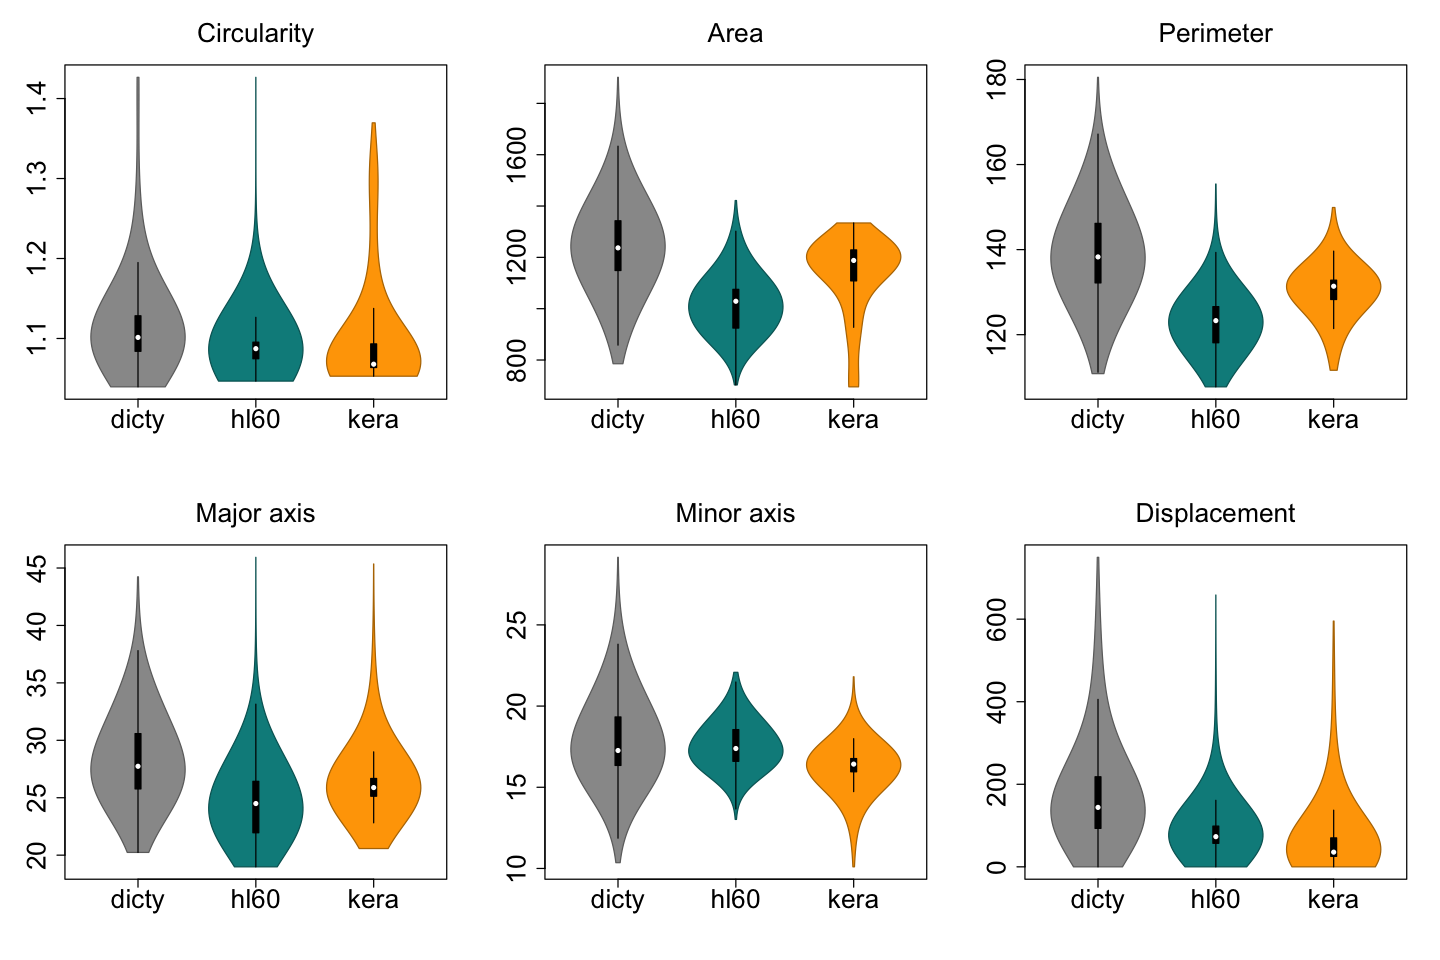

In [17]:
#Set up plot
par(mfrow = c(2,3))
options(repr.plot.width=12, repr.plot.height=8)

#Set up colors
cols = c('grey60', 'cyan4', 'orange')

#Loop through and plot
for(i in 1:ncol(l2[[1]])){
  vioplot::vioplot(l2$dicty[,i], 
                   l2$hl60[,i], 
                   l2$kera[,i],
                   names = c('dicty', 'hl60', 'kera'),
                   col = cols,
                   border = darken_color(cols),
                   cex.lab = 2, 
                   cex.axis = 2, 
                   cex.names = 2)
  title(main = colnames(l2[[1]][i]), 
        cex.main = 2, 
        font.main = 1)}